# Setup

## Imports

In [32]:
from IPython.display import clear_output

!pip3 install pyprind

clear_output()

In [33]:
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as poly

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pylab as pl
import pandas as pd
import gzip

import os
import glob
import time
import random
import json
import copy
import pyprind
import tqdm
import itertools
import pickle as pkl
from dataclasses import dataclass, field
from collections import Counter
from typing import Union, List, Dict, Any, Optional, cast

import torch
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Utility

In [34]:
def one_hot(x, num_classes=2):
    return torch.nn.functional.one_hot(x, num_classes=num_classes).squeeze(1)

In [35]:
def binary(x, width, channel_size):
    bits = width*channel_size
    mask = 2**torch.arange(bits-1,-1,-1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte().reshape(x.size(0), args.width, args.channel_size)

In [36]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [37]:
class Histogram_Counter:
    def __init__(self, low, high, bins=10, experiment='counter'):
        self.experiment = experiment
        self.delta = (high-low)/bins
        self.round = int(np.ceil(np.log10(bins)))
        self.ranges = [round(low+i*self.delta, self.round) for i in range(bins+1)]

        if os.path.exists(f'{self.experiment}.pkl'):
            self.counts = self.load()
        else:
            self.counts = Counter(dict([str(key), 0] for key in self.ranges))

        self.last_save = 0

    def add(self, x):
        if torch.is_tensor(x):
            x = x.detach().cpu().numpy()
        x = self.delta * (x//self.delta)
        a, b = np.unique(x, return_counts=True)
        self.counts += Counter(dict(zip(a.round(self.round), b)))

        if sum(self.counts.values())-self.last_save >= 1000:
            self.save()
            self.last_save = sum(self.counts.values())
    
    def get_bins(self):
        values = []
        scale = 1
        for key in self.counts.keys():
            values.extend([float(key)]*(self.counts[key]//scale))
        return values

    def plot(self):
        plt.hist(self.get_bins(), bins=self.ranges, ec="k")
        plt.yticks([])
        plt.xlabel('Range')
        plt.title(self.experiment)
        plt.show()

    def save(self):
        with open(f'{self.experiment}.pkl', 'wb') as handle:
            pkl.dump(self.counts, handle, protocol=pkl.HIGHEST_PROTOCOL)

    def load(self):
        with open(f'{self.experiment}.pkl', 'rb') as handle:
            counts = pkl.load(handle)
        return counts

## Arguments

In [38]:
@dataclass
class TrainingArgs():

    seed: int = 1
    lr: float = 1e-4
    batch_size: int = 32
    num_workers: int = os.cpu_count()
    max_epochs: str = 200
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    size: int = int(1e4)
    bound: int = 10
    input_size: int = 1
    output_size: int = 1
    path_size: int = 2
    width: int = 4
    channel_size: int = 64
    use_bias: bool = False
    k: int = 1
    architecture: str = 'DNN'
    mode: str = 'Random'

    data: tuple = None

    root_dir: str = '/content/'
    checkpoint: str = '/content/'
    experiments: tuple = ('overlap_0', 'overlap_1', 'intersection', 'all')

args = TrainingArgs()

# Models

## Shallow

In [39]:
class Shallow(torch.nn.Module):
    def __init__(self, args):
        super(Shallow, self).__init__()
        self.args = args

        self.act = []
        self.fc = []
        for width in range(self.args.width):
            in_features = self.args.input_size if width==0 else self.args.channel_size
            out_features = self.args.output_size if width==self.args.width-1 else self.args.channel_size
            act = torch.ones(self.args.path_size, out_features) if width==self.args.width-1 else torch.from_numpy(np.random.choice([0, 1], size=(self.args.path_size, out_features), p=[1./2, 1./2]))

            self.act.append(act.to(self.args.device) )
            self.fc.append(nn.Linear(in_features, out_features, bias=self.args.use_bias))
            torch.nn.init.uniform_(self.fc[-1].weight, -1/out_features, 1/out_features)
            self.fc[-1].weight.data = torch.where(self.fc[-1].weight.data>0, 1/out_features, -1/out_features)
        self.fc = nn.Sequential(*self.fc)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, gate):
        out = x
        for i in range(self.args.width):
            preact = torch.stack([self.act[i][gate[j], :] for j in range(len(gate))])
            out = self.fc[i](out) * preact

        return out

In [40]:
shallow = Shallow(args).to(args.device)

In [41]:
x = torch.ones(2, 1).to(args.device)

z = shallow(x, [0, 1])

# Train

In [42]:
model = Shallow(args).to(args.device)
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
criterion = nn.MSELoss().to(args.device)

input = torch.rand(1, 1).to(args.device)
x = input.repeat(2, 1).to(args.device)
y = torch.tensor([[-1.], [1.]]).to(args.device)

I = torch.eye(2)

z = input.squeeze(-1)

init_weights = [copy.deepcopy(model.fc[i].weight) for i in range(len(model.fc))]
gates_0 = [model.act[i][0] for i in range(len(model.act))]
gates_1 = [model.act[i][1] for i in range(len(model.act))]
gates_in = [model.act[i][0]*model.act[i][1] for i in range(len(model.act))]
gates_all = [torch.ones_like(model.act[i][1]) for i in range(len(model.act))]

In [43]:
model.train()
loss = torch.tensor(100)
epochs = 0
while loss.item()>0.0001 or epochs>1000000:
    optimizer.zero_grad()
    
    y_pred = model(x, [0, 1])
    loss = criterion(y_pred, y)

    loss.backward()
    optimizer.step()
    epochs += 1

model.eval()
y_pred = torch.where(model(x, [0, 1]).detach().cpu()>0, torch.ones(1,), -1*torch.ones(1,)).to(args.device)
accuracy = ((y_pred==y).sum()/y.size(0))*100

time.sleep(2)
print(f'Training | Loss = {round(loss.item(), 4)} Accuracy = {round(accuracy.item(), 4)}')

trained_weights = [copy.deepcopy(model.fc[i].weight) for i in range(len(model.fc))]

Training | Loss = 0.0001 Accuracy = 100.0


In [44]:
model.eval()
y_pred = torch.where(model(x, [0, 1]).detach().cpu()>0, torch.ones(1,), -1*torch.ones(1,)).to(args.device)
accuracy = ((y_pred==y).sum()/y.size(0))*100

time.sleep(2)
print(f'Training | Loss = {round(loss.item(), 4)} Accuracy = {round(accuracy.item(), 4)}')

trained_weights = [copy.deepcopy(model.fc[i].weight) for i in range(len(model.fc))]

Training | Loss = 0.0001 Accuracy = 100.0


In [45]:
model(x, [0, 1])

tensor([[-0.9859],
        [ 0.9995]], device='cuda:0', grad_fn=<MulBackward0>)

In [46]:
# !rm -f *.pkl
# metrics = dict([[exp, Histogram_Counter(-1, 1, 10000, exp)] for exp in args.experiments])

---

In [47]:
z = input.squeeze(-1)

w0, g0 = init_weights[0], gates_all[0]
w1, g1 = init_weights[1], gates_all[1]
w2, g2 = init_weights[2], gates_all[2]
w3, g3 = init_weights[3], gates_all[3]

In [48]:
def find_paths(z, weights, gates):
    w0, g0 = weights[0], gates[0]
    w1, g1 = weights[1], gates[1]
    w2, g2 = weights[2], gates[2]
    w3, g3 = weights[3], gates[3]

    paths = []
    for i0 in range(len(w0)):
        for i1 in range(len(w1)):
            for i2 in range(len(w2)):
                for i3 in range(len(w3)):
                    path = ( z * w0[i0][0]*g0[i0] * w1[i1][i0]*g1[i1] * w2[i2][i1]*g2[i2] * w3[i3][i2]*g3[0]).item()
                    if g0[i0]!=0 and g1[i1]!=0 and g2[i2]!=0 and g3[0]!=0:
                        paths.append(path)
    return paths

---

In [49]:
paths_0_init = find_paths(z, init_weights, gates_0)
paths_1_init = find_paths(z, init_weights, gates_1)
paths_in_init = find_paths(z, init_weights, gates_in)
paths_all_init = find_paths(z, init_weights, gates_all)

paths_0_train = find_paths(z, trained_weights, gates_0)
paths_1_train = find_paths(z, trained_weights, gates_1)
paths_in_train = find_paths(z, trained_weights, gates_in)
paths_all_train = find_paths(z, trained_weights, gates_all)

In [50]:
paths_0_init = np.array(paths_0_init)
paths_1_init = np.array(paths_1_init)
paths_in_init = np.array(paths_in_init)
paths_all_init = np.array(paths_all_init)

paths_0_train = np.array(paths_0_train)
paths_1_train = np.array(paths_1_train)
paths_in_train = np.array(paths_in_train)
paths_all_train = np.array(paths_all_train)

In [51]:
l = min(min(min(paths_0_init), min(paths_1_init)), min(min(paths_in_init), min(paths_all_init)))
r = max(max(max(paths_0_init), max(paths_1_init)), max(max(paths_in_init), max(paths_all_init)))

---

In [52]:
paths_0_init

array([ 1.42101476e-06,  1.42101476e-06,  1.42101476e-06, ...,
       -1.42101476e-06,  1.42101476e-06, -1.42101476e-06])

In [53]:
len(paths_0_train[paths_0_train<0]), len(paths_0_train[paths_0_train>0])

(21116, 12544)

In [54]:
len(paths_1_train[paths_1_train<0]), len(paths_1_train[paths_1_train>0])

(13004, 20656)

In [55]:
drange = np.where(np.abs(paths_0_init)>10e-10)

paths_0_init_filter = paths_0_init[drange]
paths_0_train_filter = paths_0_train[drange]
temp = paths_0_init_filter/paths_0_train_filter

print(temp[temp<0].shape[0]/paths_0_init_filter.shape[0])

np.abs(paths_0_init_filter[np.where(temp<0)] - paths_0_train_filter[np.where(temp<0)]).mean() / np.abs(paths_0_init).mean()

0.3118538324420677


20.98016559826059

In [56]:
len(paths_0_train)

33660

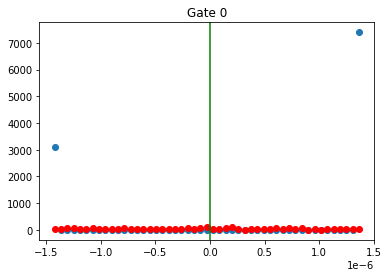

In [57]:
drange = np.where(np.abs(paths_0_init)>0)

paths_0_init_filter = paths_0_init[drange]
paths_0_train_filter = paths_0_train[drange]
temp = paths_0_init_filter/paths_0_train_filter

bins = np.linspace(l, r, 50)
hist_init, _ = init = np.histogram(paths_0_init_filter[np.where(temp<0)], bins=bins)
hist_train, _ = np.histogram(paths_0_train_filter[np.where(temp<0)], bins=bins)

plt.scatter(bins[:-1], hist_init)
plt.scatter(bins[:-1], hist_train, color='red')
plt.axvline(x = 0, color = 'g', label = 'axvline - full height')
plt.title('Gate 0')
hist_train_0 = hist_train

In [58]:
drange = np.where(np.abs(paths_1_init)>10e-10)

paths_1_init_filter = paths_1_init[drange]
paths_1_train_filter = paths_1_train[drange]
temp = paths_1_init_filter/paths_1_train_filter
print(temp[temp<0].shape[0]/paths_1_init_filter.shape[0])

np.abs(paths_1_init_filter[np.where(temp<0)] - paths_1_train_filter[np.where(temp<0)]).mean() / np.abs(paths_1_init).mean()

0.3265597147950089


20.224906097777513

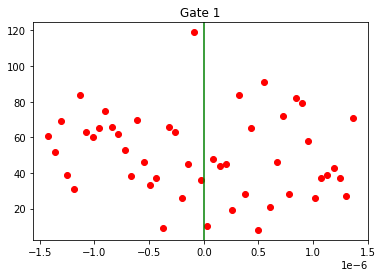

In [59]:
drange = np.where(np.abs(paths_1_init)>0)

paths_1_init_filter = paths_1_init[drange]
paths_1_train_filter = paths_1_train[drange]
temp = paths_1_init_filter/paths_1_train_filter

bins = np.linspace(l, r, 50)
hist_init, _ = init = np.histogram(paths_1_init_filter[np.where(temp<0)], bins=bins)
hist_train, _ = np.histogram(paths_1_train_filter[np.where(temp<0)], bins=bins)

# plt.scatter(bins[:-1], hist_init)
plt.scatter(bins[:-1], hist_train, color='red')
plt.axvline(x = 0, color = 'g', label = 'axvline - full height')
plt.title('Gate 1')
hist_train_1 = hist_train

In [60]:
-np.logspace(np.log10(1e-8), np.log10(1e-1), 5)[::-1]

array([-1.00000000e-01, -1.77827941e-03, -3.16227766e-05, -5.62341325e-07,
       -1.00000000e-08])

In [61]:
h0n, x0n = np.histogram(-paths_0_train[paths_0_train<0], bins=np.logspace(np.log10(1e-10), 0, 500))
h0p, x0p = np.histogram(paths_0_train[paths_0_train>0], bins=np.logspace(np.log10(1e-10), 0, 500))
h0p, x0p = h0p[::-1], x0p[::-1]

In [62]:
sum = 0
for i in range(len(h0n)):
    sum += -h0n[i]*x0n[i]
    print(h0n[i], ',', np.format_float_scientific(-x0n[i], precision=3), ',', np.format_float_scientific(-h0n[i]*x0n[i], precision=2), ',', np.format_float_scientific(sum, precision=2))

print('\n######\n')
sum = 0
for i in range(len(h0p)):
    sum += h0p[i]*x0p[i]
    print(h0p[i], ',', np.format_float_scientific(x0p[i], precision=3), ',', np.format_float_scientific(h0p[i]*x0p[i], precision=2), ',', np.format_float_scientific(sum, precision=2))

0 , -1.e-10 , 0.e+00 , 0.e+00
0 , -1.047e-10 , 0.e+00 , 0.e+00
0 , -1.097e-10 , 0.e+00 , 0.e+00
0 , -1.148e-10 , 0.e+00 , 0.e+00
0 , -1.203e-10 , 0.e+00 , 0.e+00
0 , -1.26e-10 , 0.e+00 , 0.e+00
0 , -1.319e-10 , 0.e+00 , 0.e+00
0 , -1.381e-10 , 0.e+00 , 0.e+00
0 , -1.447e-10 , 0.e+00 , 0.e+00
0 , -1.515e-10 , 0.e+00 , 0.e+00
0 , -1.586e-10 , 0.e+00 , 0.e+00
0 , -1.661e-10 , 0.e+00 , 0.e+00
0 , -1.74e-10 , 0.e+00 , 0.e+00
0 , -1.822e-10 , 0.e+00 , 0.e+00
0 , -1.908e-10 , 0.e+00 , 0.e+00
0 , -1.998e-10 , 0.e+00 , 0.e+00
0 , -2.092e-10 , 0.e+00 , 0.e+00
0 , -2.191e-10 , 0.e+00 , 0.e+00
0 , -2.295e-10 , 0.e+00 , 0.e+00
0 , -2.403e-10 , 0.e+00 , 0.e+00
0 , -2.517e-10 , 0.e+00 , 0.e+00
0 , -2.635e-10 , 0.e+00 , 0.e+00
0 , -2.76e-10 , 0.e+00 , 0.e+00
0 , -2.890e-10 , 0.e+00 , 0.e+00
0 , -3.027e-10 , 0.e+00 , 0.e+00
0 , -3.17e-10 , 0.e+00 , 0.e+00
0 , -3.319e-10 , 0.e+00 , 0.e+00
0 , -3.476e-10 , 0.e+00 , 0.e+00
0 , -3.640e-10 , 0.e+00 , 0.e+00
0 , -3.812e-10 , 0.e+00 , 0.e+00
0 , -3.992e-10 , 

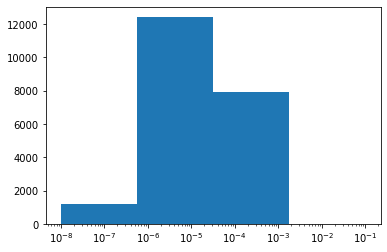

In [ ]:
pl.hist(-paths_0_train[paths_0_train<0], bins=np.logspace(np.log10(1e-8), np.log10(1e-1), 5))
pl.gca().set_xscale("log")
pl.show()

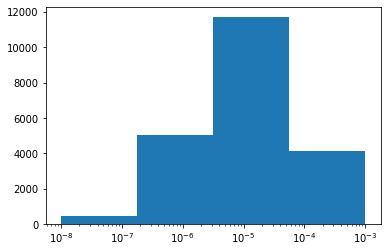

In [ ]:
pl.hist(paths_1_train, bins=np.logspace(np.log10(1e-8),np.log10(1e-3), 5))
pl.gca().set_xscale("log")
pl.show()

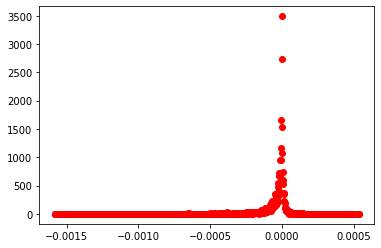

In [ ]:
bins = np.linspace(min(paths_0_train), max(paths_0_train), 1000)
hist, _ = np.histogram(paths_0_train, bins=bins)

plt.scatter(bins[:-1], hist, color='red')

In [ ]:
for r in range(len(y)):
    print(np.format_float_scientific(x[r]), y[r], (x[r]+x[r+1])/2 * y[r])

-1.583813806064427e-03 13 -0.020450180761558426
-1.5623678495599465e-03 13 -0.02017138332700018
-1.5409218930554662e-03 0 -0.0
-1.5194759365509856e-03 0 -0.0
-1.4980299800465052e-03 0 -0.0
-1.4765840235420249e-03 0 -0.0
-1.4551380670375445e-03 0 -0.0
-1.4336921105330641e-03 0 -0.0
-1.4122461540285835e-03 0 -0.0
-1.3908001975241032e-03 0 -0.0
-1.3693542410196228e-03 0 -0.0
-1.3479082845151424e-03 0 -0.0
-1.326462328010662e-03 0 -0.0
-1.3050163715061817e-03 0 -0.0
-1.2835704150017013e-03 0 -0.0
-1.2621244584972208e-03 0 -0.0
-1.2406785019927404e-03 0 -0.0
-1.21923254548826e-03 0 -0.0
-1.1977865889837794e-03 0 -0.0
-1.176340632479299e-03 0 -0.0
-1.1548946759748187e-03 0 -0.0
-1.1334487194703383e-03 0 -0.0
-1.112002762965858e-03 0 -0.0
-1.0905568064613776e-03 0 -0.0
-1.0691108499568973e-03 0 -0.0
-1.0476648934524169e-03 0 -0.0
-1.0262189369479363e-03 0 -0.0
-1.004772980443456e-03 0 -0.0
-9.833270239389756e-04 0 -0.0
-9.618810674344951e-04 0 -0.0
-9.404351109300147e-04 0 -0.0
-9.18989154425

(array([3.0828e+04, 2.6480e+03, 5.7800e+02, 2.0000e+02, 6.2000e+01,
        4.3000e+01, 1.9000e+01, 1.6000e+01, 2.2000e+01, 3.6000e+01]),
 array([-9.95510345e-05,  6.89702007e-05,  2.37491436e-04,  4.06012671e-04,
         5.74533906e-04,  7.43055141e-04,  9.11576377e-04,  1.08009761e-03,
         1.24861885e-03,  1.41714008e-03,  1.58566132e-03]),
 <BarContainer object of 10 artists>)

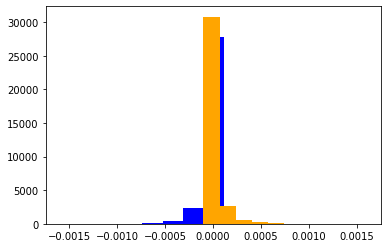

In [ ]:
plt.hist(paths_0_train, color='blue')
plt.hist(paths_1_train, color='orange')

---

In [ ]:
paths_0_train = np.array(paths_0_train)
print(paths_0_train[np.where(paths_0_train<0)].shape[0] / paths_0_train.shape[0])

0.699041699041699


In [ ]:
paths_1_train = np.array(paths_1_train)
print(paths_1_train[np.where(paths_1_train>0)].shape[0] / paths_1_train.shape[0])

0.621270172994311


Text(0.5, 1.0, 'Gate 1')

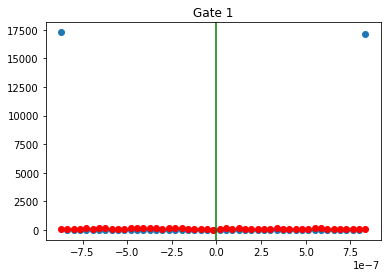

In [ ]:
bins = np.linspace(l, r, 50)
hist_init, _ = init = np.histogram(paths_1_init, bins=bins)
hist_train, _ = np.histogram(paths_1_train, bins=bins)

plt.scatter(bins[:-1], hist_init)
plt.scatter(bins[:-1], hist_train, color='red')
plt.axvline(x = 0, color = 'g', label = 'axvline - full height')
plt.title('Gate 1')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# paths = find_paths(z, init_weights, gates_0)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[0].hist(paths_0_init, bins=np.linspace(l, r, 20), )
axes[0].set_title('Initialization')

# paths = find_paths(z, trained_weights, gates_0)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[1].hist(paths_0_train, bins=np.linspace(l, r, 20), color='orange')
axes[1].set_title('Trained')

fig.suptitle('Gate 0')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# paths = find_paths(z, init_weights, gates_1)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[0].hist(paths_1_init, bins=np.linspace(l, r, 20))
axes[0].set_title('Initialization')

# paths = find_paths(z, trained_weights, gates_1)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[1].hist(paths_1_train, bins=np.linspace(l, r, 20), color='orange')
axes[1].set_title('Trained')

fig.suptitle('Gate 1')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# paths = find_paths(z, init_weights, gates_in)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[0].hist(paths_in_init, bins=np.linspace(l, r, 20))
axes[0].set_title('Initialization')

# paths = find_paths(z, trained_weights, gates_0)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[1].hist(paths_in_train, bins=np.linspace(l, r, 20), color='orange')
axes[1].set_title('Trained')

fig.suptitle('Gate Intersection')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# paths = find_paths(z, init_weights, gates_all)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[0].hist(paths_all_init, bins=np.linspace(l, r, 20))
axes[0].set_title('Initialization')

# paths = find_paths(z, trained_weights, gates_all)
# l = max(min(paths), -1)
# r = min(max(paths), 1)
axes[1].hist(paths_all_train, bins=np.linspace(l, r, 20), color='orange')
axes[1].set_title('Trained')

fig.suptitle('Gate All')
plt.show()